2024-04-23 04:09:42.674904: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 04:09:42.674966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 04:09:42.708953: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-23 04:09:42.777557: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 04:09:43.461187: W tensorflow/compiler/tf2

Found 28709 files belonging to 7 classes.


2024-04-23 04:09:45.010407: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-04-23 04:09:45.010431: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: darksst
2024-04-23 04:09:45.010436: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: darksst
2024-04-23 04:09:45.010510: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.171.4
2024-04-23 04:09:45.010526: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 470.239.6
2024-04-23 04:09:45.010530: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 470.239.6 does not match DSO version 535.171.4 -- cannot find working devices in this configuration


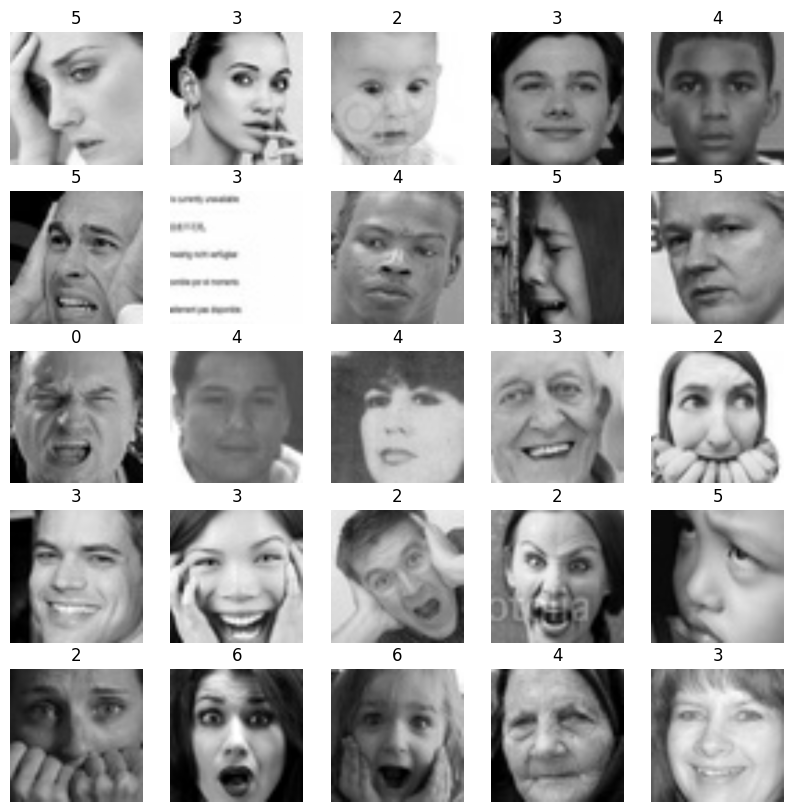

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

def preprocess_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, [224, 224], method='bilinear')
    image = tf.image.grayscale_to_rgb(image)
    return image, label

def prepare_dataset(directory, batch_size=32):
    # Create a dataset from images in directory, assuming subdirectories are class labels
    dataset = image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='int',  # You can change this to 'categorical' if you need one-hot encoded labels
        image_size=(48, 48),  # Directly read images at the target size
        color_mode='grayscale',
        batch_size=batch_size,
        shuffle=True
    )
    # Apply preprocessing to each batch
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    # Prefetch to optimize speed
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Example usage:
train_directory = '/home/darksst/Desktop/FinalProject/project_1_dataset/train'
train_dataset = prepare_dataset(train_directory)

# Visualize some images
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(min(len(image_batch), 25)):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(label_batch[n].numpy())
        plt.axis('off')
    plt.show()

# Fetch one batch of data
for images, labels in train_dataset.take(1):
    show_batch(images, labels)


In [2]:
def prepare_datasets(directory, batch_size=100, train_val_split=0.8):
    # Compute the number of files to use for training
    total_files = len(tf.io.gfile.glob(directory + '/*/*.jpg'))
    train_size = int(train_val_split * total_files)
    val_size = total_files - train_size
    
    # Load the dataset with training and validation splits
    dataset = image_dataset_from_directory(
        directory,
        validation_split=1-train_val_split,
        subset="training",
        seed=123,
        labels='inferred',
        label_mode='categorical',  # Since we are doing multi-class classification
        image_size=(48, 48),
        color_mode='grayscale',
        batch_size=batch_size,
        shuffle=True
    )

    validation_dataset = image_dataset_from_directory(
        directory,
        validation_split=1-train_val_split,
        subset="validation",
        seed=123,
        labels='inferred',
        label_mode='categorical',
        image_size=(48, 48),
        color_mode='grayscale',
        batch_size=batch_size,
        shuffle=True
    )

    # Apply preprocessing to both datasets
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Prefetch to optimize speed
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset, validation_dataset


In [3]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

def build_model(num_classes):
    input_tensor = Input(shape=(224, 224, 3))
    base_model = DenseNet121(include_top=False, weights='imagenet', input_tensor=input_tensor)
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

model = build_model(7)


In [4]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
train_directory = '/home/darksst/Desktop/FinalProject/project_1_dataset/train'
train_dataset, validation_dataset = prepare_datasets(train_directory)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Epoch 1/10
 19/230 [=>............................] - ETA: 35:15 - loss: 1.8605 - accuracy: 0.3158

In [8]:
'''DenseCNN = '/home/darksst/Desktop/FinalProject/DenseCNN'
Densehd = '/home/darksst/Desktop/FinalProject/Dense.h5'
DenseKeras = '/home/darksst/Desktop/FinalProject/DenseKeras.keras'
model.save(DenseCNN)
#model.save(Densehd, save_format='h5')
model.save(DenseKeras, save_format='keras')'''

INFO:tensorflow:Assets written to: /home/darksst/Desktop/FinalProject/DenseCNN/assets


INFO:tensorflow:Assets written to: /home/darksst/Desktop/FinalProject/DenseCNN/assets
